### Update Vn and Mun

In [75]:
import math
def gen_E_zn(zn, m, p):
    # assert check
    assert(zn.shape == (m, ))
    E_zn = np.zeros((m, p))
    row = 0
    for z in zn:
        E_zn[row, z] = 1.0
        row += 1
    # print("E_zn: {}".format(E_zn))
    return E_zn

def update_vn(vn_old, zn, sigma, lamda, m, p):
    # assert check
    assert(vn_old.shape == (p, p))
    assert(zn.shape == (m, ))
    assert(sigma.shape == (p, p))
    
    # generate E_zn
    E_zn = gen_E_zn(zn, m, p)
    
    # generate sigma_zn
    sigma_zn = sigma[zn, :][:, zn]
    # print("sigma_zn: {}".format(sigma_zn))
    sigma_zn_inv = np.linalg.inv(sigma_zn)
    # print("sigma_zn_inv: {}".format(sigma_zn_inv))
    
    # calculate vn update
    tmp = np.matmul(E_zn.T, sigma_zn_inv)
    tmp = np.matmul(tmp, E_zn)
    # print("tmp: {}".format(tmp))
    vn_new_inv = (1 - lamda) * np.linalg.inv(vn_old) + tmp
    return np.linalg.inv(vn_new_inv)

def update_mun(mun_old, zn, sigma, lamda, m, p, Xn, vn):
    # assert check
    assert(mun_old.shape == (p, ))
    assert(zn.shape == (m, ))
    assert(sigma.shape == (p, p))
    assert(Xn.shape == (m, ))
    assert(vn.shape == (p, p))
    
    # generate E_zn
    E_zn = gen_E_zn(zn, m, p)
    
    # generate sigma_zn
    sigma_zn = sigma[zn, :][:, zn]
    # print("sigma_zn: {}".format(sigma_zn))
    sigma_zn_inv = np.linalg.inv(sigma_zn)
    
    # calculate mun update
    tmp = np.matmul(E_zn.T, sigma_zn_inv)
    tmp = np.matmul(tmp, Xn)
    # print("tmp: {}".format(tmp))
    mun_new = np.matmul(vn, (1 - lamda) * mun_old + tmp)
    return mun_new

### CMAB for adaptively sampling Zt

In [76]:
def CMAB(p, q, m, lamda, sigma, Xn):
    # assert check
    assert(Xn.shape == (L, p))
    
    # init mu and v, not sure
    mun_old = np.zeros((p, ))
    vn_old = np.zeros((p, p))
    np.fill_diagonal(vn_old, 1.0)
    
    # observe all sensors for once
    for i in range(0, math.ceil(p/m)):
        zn = np.arange(i*m, (i + 1) * m)
        # print("zn: {}".format(zn))
        Xn_observe = Xn[i, zn]
        # print("Xn_observe: {}".format(Xn_observe))
        
        # update vn and mun
        vn_new = update_vn(vn_old, zn, sigma, lamda, m, p)
        # print("vn_old: {}".format(vn_old))
        # print("vn_new: {}".format(vn_new))
        mun_new = update_mun(mun_old, zn, sigma, lamda, m, p, Xn_observe, vn_new)
        # print("mun_old: {}".format(mun_old))
        # print("mun_new: {}".format(mun_new))
        
        # copy new to old
        vn_old = np.copy(vn_new)
        mun_old = np.copy(mun_new)
        
    # pick zn and further update

### Generate the sensor environment

(200, 10)
[-1.18567146 -1.85429124 -0.08888008 -0.97094313 -0.25661465 -0.93320058
 -0.90916348 -1.73332101 -0.51568052  1.23689943]


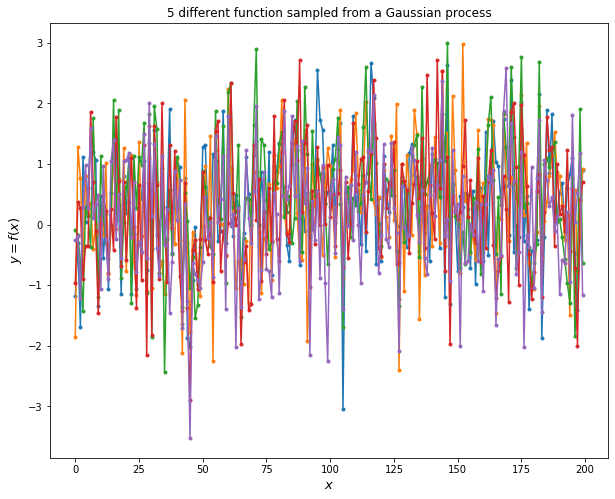

In [77]:
import numpy as np
p = 10 # total # of sensors
q = 4 # total # of misbehaved sensors
m = 5 # total # of observed sensors
lamda = 0.1 # lambda

tau = 50 # error ocurrance time
L = 200 # length of one exp episode
N = 10000 # total experiment times

delta = 0.25
# some confusion on sigma[i,i]. set it to 1.0 here. not sure.
sigma = np.full((p, p), 0.5)
np.fill_diagonal(sigma, 1.0)

# generate input data streams
def gen_input(p, q, delta, sigma, tau, L):
    # generate mu_c
    mu = np.zeros((p, )) # normal mean
    mu_c = np.zeros((p, ))
    mu_c[:q] = delta # first q elements to delta, error mean
    # print(mu_c)
    
    # generate multi-variate gaussian
    Xn = np.random.multivariate_normal(mu, sigma, tau)
    # print(Xn.shape) # (50, 10), first dimension is exp. episode
    Xn_abnormal = np.random.multivariate_normal(mu_c, sigma, L - tau)
    # print(Xn_abnormal.shape) # (150, 10)
    Xn = np.vstack((Xn, Xn_abnormal))
    return Xn

def visualize(Xn):
    print(Xn.shape)
    print(Xn[0, :])
    import matplotlib.pyplot as plt
    # Plot the sampled functions
    plt.figure(figsize=(10, 8))
    X = np.arange(L)
    for i in range(5):
        plt.plot(X, Xn[:, i], linestyle='-', marker='o', markersize=3)
    plt.xlabel('$x$', fontsize=13)
    plt.ylabel('$y = f(x)$', fontsize=13)
    plt.title((
        '5 different function sampled from a Gaussian process'))
    plt.show()

    
Xn = gen_input(p, q, delta, sigma, tau, L)
visualize(Xn)

In [78]:
CMAB(p, q, m, lamda, sigma, Xn)